# 03-CNN_Applications-Indoor-Object-Detection
Using the indoor-object-detection dataset, my goal is to develop and train a deep learining model that will recognise indoor items from an image.

# Importing the required libraries

In [1]:
%%capture
!pip install --upgrade ultralytics
!pip install --upgrade -U ray[tune]
!pip install -U ipywidgets

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml

import torch
import gc

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

from PIL import Image
import cv2

from ultralytics import YOLO

%matplotlib inline

! wandb disabled

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
W&B disabled.


# Importing and preparing the dataset of images

In [3]:
class CFG:
    DEBUG = False
    FRACTION = 0.05 if DEBUG else 1.0
    SEED = 42
    
    CLASSES = ['door',
               'cabinetDoor',
               'refrigeratorDoor',
               'window',
               'chair',
               'table',
               'cabinet',
               'couch',
               'openedDoor',
               'pole']
    
    NUM_CLASSES_TO_TRAIN = len(CLASSES)
    
    EPOCHS = 3 if DEBUG else 100 #70
    BATCH_SIZE = 16
    
    BASE_MODEL = 'yolov9s'
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'ppe_css_{EPOCHS}_epochs'
    
    OPTIMIZER = 'auto'
    LR = 1e-5
    LR_FACTOR = 0.01
    WEIGHT_DECAY = 5e-4
    DROPOUT = 0.0
    PATIENCE = 30
    PROFILE = False
    LABEL_SMOOTHING = 0.0
    
    CUSTOM_DATASET_DIR = '/kaggle/input/indoor-object-detection'
    OUTPUT_DIR = '/kaggle/working/'

In [4]:
dict_file = {
    'train': os.path.join(CFG.CUSTOM_DATASET_DIR, 'train'),
    'val': os.path.join(CFG.CUSTOM_DATASET_DIR, 'valid'),
    'test': os.path.join(CFG.CUSTOM_DATASET_DIR, 'test'),
    'nc': CFG.NUM_CLASSES_TO_TRAIN,
    'names': CFG.CLASSES
    }

with open(os.path.join(CFG.OUTPUT_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [5]:
### read yaml file created
def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- door
- cabinetDoor
- refrigeratorDoor
- window
- chair
- table
- cabinet
- couch
- openedDoor
- pole
nc: 10
test: /kaggle/input/indoor-object-detection/test
train: /kaggle/input/indoor-object-detection/train
val: /kaggle/input/indoor-object-detection/valid



# Looking into the dataset components

In [6]:
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')

    plt.show()

In [7]:
dict_file['train']

'/kaggle/input/indoor-object-detection/train'

Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (768, 1024, 3) 



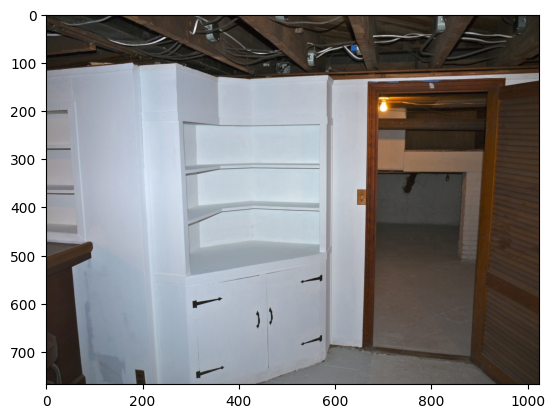

In [8]:
example_image_path = f'{CFG.CUSTOM_DATASET_DIR}/train/images/000bf0ddff4c7310.jpg'

display_image(example_image_path)

In [9]:
def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED):
    random.seed(seed)
    
    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]
    
    # Ensure that we have at least num_images files to choose from 
    if len(image_files) < num_images: 
        raise ValueError("Not enough images in the folder")
    
    # Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)
    
    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
    
    for i, file_name in enumerate(selected_files):
        # Open and display the images using PIL
        img = Image.open(os.path.join(folder_path, file_name))
        
        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]
            
        ax.imshow(img)
        ax.axis('off')
        
    # Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])
    
    plt.tight_layout()
    plt.show()

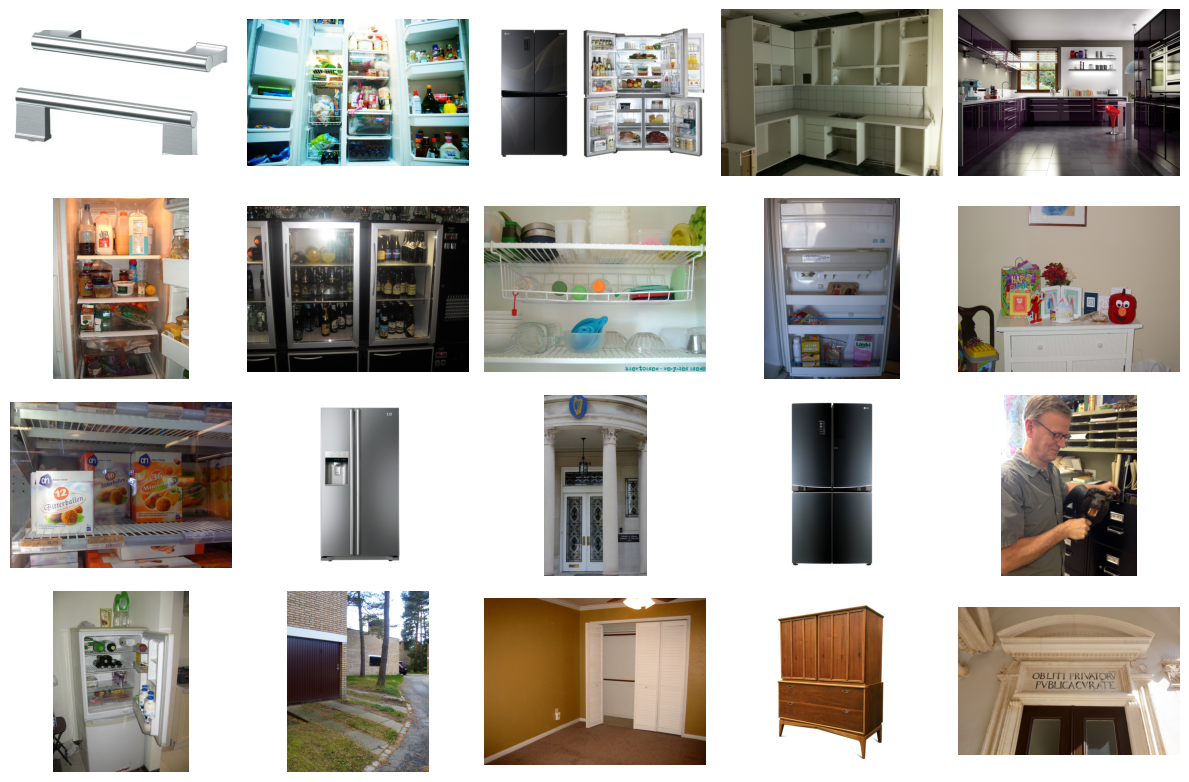

In [10]:
folder_path = CFG.CUSTOM_DATASET_DIR + '/train/images'
plot_random_images_from_folder(folder_path)

In [11]:
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)
    
    # Check if the image file is read correctly
    if img is None:
        raise ValueError("Could not read image file")
        
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype
    }
    
    return properties

In [12]:
img_properties = get_image_properties(example_image_path)
img_properties

{'width': 1024, 'height': 768, 'channels': 3, 'dtype': dtype('uint8')}

In [13]:
class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

class_stat = {}
data_len = {}
class_info = []

    
for mode in ['train', 'valid', 'test']:
    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

    path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})
            
dataset_stats_df = pd.DataFrame(class_info)
with pd.option_context('display.max_columns', None):
    display(dataset_stats_df)


,Mode,door,cabinetDoor,refrigeratorDoor,window,chair,table,cabinet,couch,openedDoor,pole,Data_Volume
0,train,309,448,332,187,105,165,138,22,68,14,1008
1,valid,63,99,85,39,24,30,28,1,13,4,230
2,test,25,42,1,49,38,41,44,31,18,3,104


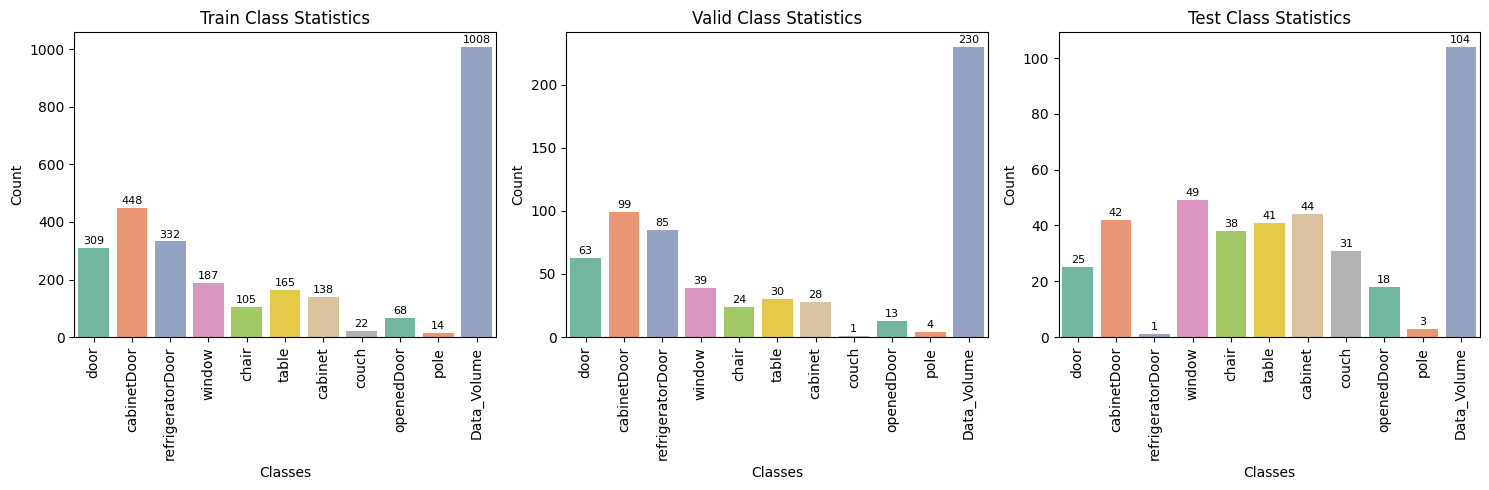

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(
        data=dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns="Mode"),
        orient='v',
        ax=axes[i],
        palette='Set2'        
    )
    
    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90)
    
    # add annotations on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

# Training the model.

In [15]:
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

results = model.predict(
    source = example_image_path,
    
    classes = [0],
    conf = 0.30,
#     device = [0, 1], # inference with dual GPU
    device = None, # inference with GPU
    imgsz = (img_properties['height'], img_properties['width']),
    
    save = True,
    save_txt = True,
    save_conf = True,
    exist_ok = True
)

100%|██████████| 14.7M/14.7M [00:00<00:00, 118MB/s] 



image 1/1 /kaggle/input/indoor-object-detection/train/images/000bf0ddff4c7310.jpg: 768x1024 (no detections), 32.3ms
Speed: 9.8ms preprocess, 32.3ms inference, 257.1ms postprocess per image at shape (1, 3, 768, 1024)
Results saved to runs/detect/predict
0 label saved to runs/detect/predict/labels


Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (768, 1024, 3) 



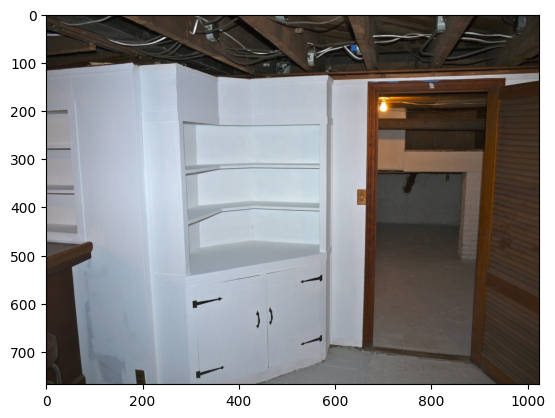

In [16]:
example_image_inference_output = example_image_path.split('/')[-1]
display_image(f'runs/detect/predict/{example_image_inference_output}')

In [17]:
print('Model:', CFG.BASE_MODEL_WEIGHTS)
print('Epochs: ', CFG.EPOCHS)
print('Batch: ', CFG.BATCH_SIZE)

Model: yolov9s.pt
Epochs:  100
Batch:  16


In [18]:
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

In [19]:
# def cleanup_memory_callback(trainer):
#     gc.collect()
#     torch.cuda.empty_cache()
#     print("Memory cleaned after epoch")

def cleanup_before_training():
    gc.collect()
    torch.cuda.empty_cache()
    print("Memory cleaned befort training")

In [20]:
%%time

cleanup_before_training()
os.environ['WANDB_MODE'] = 'offline'

### train
model.train(
    data = os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),

    task = 'detect',

    imgsz = (img_properties['height'], img_properties['width']),

    epochs = CFG.EPOCHS,
    batch = CFG.BATCH_SIZE,
    optimizer = CFG.OPTIMIZER,
    lr0 = CFG.LR,
    lrf = CFG.LR_FACTOR,
    weight_decay = CFG.WEIGHT_DECAY,
    dropout = CFG.DROPOUT,
    fraction = CFG.FRACTION,
    patience = CFG.PATIENCE,
    profile = CFG.PROFILE,
    label_smoothing = CFG.LABEL_SMOOTHING,

    name = f'{CFG.BASE_MODEL}_{CFG.EXP_NAME}',
    seed = CFG.SEED,
    
    val = True,
    amp = True,    
    exist_ok = True,
    resume = False,
    device = [0], 
#     device = None, # CPU run
    verbose = False,
)

Memory cleaned befort training
Ultralytics 8.3.35 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov9s.pt, data=/kaggle/working/data.yaml, epochs=100, time=None, patience=30, batch=16, imgsz=(768, 1024), save=True, save_period=-1, cache=False, device=[0], workers=8, project=None, name=yolov9s_ppe_css_100_epochs, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_cro

100%|██████████| 755k/755k [00:00<00:00, 16.2MB/s]


Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     31104  ultralytics.nn.modules.block.ELAN1           [64, 64, 64, 32]              
  3                  -1  1     73984  ultralytics.nn.modules.block.AConv           [64, 128]                     
  4                  -1  1    258432  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 128, 128, 64, 3]        
  5                  -1  1    221568  ultralytics.nn.modules.block.AConv           [128, 192]                    
  6                  -1  1    579648  ultralytics.nn.modules.block.RepNCSPELAN4    [192, 192, 192, 96, 3]        
  7                  -1  1    442880  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 13.0MB/s]


AMP: checks passed ✅
WARNING ⚠️ updating to 'imgsz=1024'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'


train: Scanning /kaggle/input/indoor-object-detection/train/labels... 1008 images, 120 backgrounds, 0 corrupt: 100%|██████████| 1012/1012 [00:04<00:00, 217.90it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/indoor-object-detection/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/indoor-object-detection/valid/labels... 230 images, 31 backgrounds, 0 corrupt: 100%|██████████| 230/230 [00:00<00:00, 252.32it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/indoor-object-detection/valid is not writeable, cache not saved.


Plotting labels to runs/detect/yolov9s_ppe_css_100_epochs/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=1e-05' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.0005), 227 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 2 dataloader workers
Logging results to runs/detect/yolov9s_ppe_css_100_epochs
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      12.7G      1.666      3.339      1.707         40       1024: 100%|██████████| 64/64 [00:56<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]

                   all        230       1289      0.509      0.277      0.222      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      12.8G      1.464      1.996      1.521         23       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.61it/s]

                   all        230       1289      0.616      0.204      0.208      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      12.7G      1.477      1.876      1.531         22       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.59it/s]

                   all        230       1289      0.479      0.206      0.153     0.0805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      12.5G      1.508      1.916      1.568         41       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.70it/s]

                   all        230       1289      0.375      0.265      0.164     0.0831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      12.6G      1.484      1.797      1.552         31       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.70it/s]

                   all        230       1289      0.572      0.186      0.209       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      12.7G      1.448      1.652      1.521         24       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]

                   all        230       1289      0.614      0.227      0.229       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      12.6G      1.434      1.613       1.52         49       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.71it/s]

                   all        230       1289      0.507      0.363      0.362      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      12.8G      1.419      1.613      1.519         28       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]

                   all        230       1289      0.581      0.257      0.241      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      12.5G      1.428      1.577      1.518         22       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.67it/s]

                   all        230       1289      0.509      0.354      0.307      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      12.8G      1.399      1.495        1.5         36       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]

                   all        230       1289      0.364      0.301      0.283      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      12.8G      1.394      1.487      1.487         64       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]

                   all        230       1289      0.523      0.281      0.272      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      12.5G      1.365      1.449      1.478         41       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]

                   all        230       1289      0.578      0.316      0.288      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      12.3G      1.337      1.417      1.467         32       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]

                   all        230       1289      0.522      0.339      0.318      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      12.3G      1.342      1.379      1.462         29       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        230       1289      0.565      0.274      0.297      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      12.8G      1.336       1.34      1.459         31       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.76it/s]

                   all        230       1289      0.467      0.295      0.295      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      12.6G      1.356      1.359      1.457         67       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.70it/s]

                   all        230       1289      0.532      0.326      0.324       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      12.3G      1.318      1.321       1.45         12       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.70it/s]

                   all        230       1289      0.462      0.361      0.316      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      12.6G      1.304      1.282      1.427         58       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]

                   all        230       1289      0.477      0.343      0.318      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      12.9G      1.288      1.241      1.427         60       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]

                   all        230       1289      0.509      0.313      0.323      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      12.7G      1.289      1.243      1.414         25       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.67it/s]

                   all        230       1289       0.67      0.287      0.306      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      12.7G      1.288       1.16      1.403         40       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


                   all        230       1289      0.517      0.368      0.319      0.184

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      12.6G      1.273      1.183      1.412         16       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]

                   all        230       1289      0.401      0.332      0.339      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      12.7G      1.242      1.147       1.39         42       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.71it/s]

                   all        230       1289      0.489      0.348      0.328       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      12.8G      1.261      1.165      1.402         27       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]

                   all        230       1289      0.445       0.34      0.331      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      12.6G      1.251      1.156      1.402         32       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]

                   all        230       1289      0.481      0.398      0.367      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100        13G      1.236      1.116      1.377         25       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.76it/s]

                   all        230       1289      0.378      0.368      0.351      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      12.8G      1.223      1.085      1.397         46       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]

                   all        230       1289      0.631      0.342      0.351      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      12.7G      1.231      1.057      1.372         47       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]

                   all        230       1289      0.345       0.41      0.356      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      12.6G      1.225      1.014      1.361         33       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.77it/s]

                   all        230       1289       0.48      0.449      0.449      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      12.3G      1.209      1.025      1.362         36       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.87it/s]

                   all        230       1289      0.575      0.336      0.374      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      12.3G      1.199     0.9926      1.354         22       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.86it/s]

                   all        230       1289      0.567      0.342      0.379      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      12.8G      1.195     0.9909      1.353         34       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]

                   all        230       1289      0.556      0.296      0.347      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      12.6G      1.179     0.9548      1.335         52       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]

                   all        230       1289      0.384      0.497      0.369      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      12.6G      1.162     0.9618      1.347         46       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.77it/s]

                   all        230       1289      0.591      0.359      0.373      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      12.8G      1.164     0.9537      1.335         41       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]

                   all        230       1289       0.39      0.381       0.38      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      12.7G      1.145     0.9322      1.325         75       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]

                   all        230       1289      0.585      0.336      0.378      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      13.2G      1.147     0.9191      1.328         31       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.78it/s]

                   all        230       1289      0.407      0.374      0.364      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      12.5G      1.141     0.9026      1.305         29       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]

                   all        230       1289      0.365      0.502      0.408      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      12.7G      1.143     0.8903      1.319        123       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.78it/s]

                   all        230       1289      0.353      0.404      0.373      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      12.7G      1.125     0.8901      1.319         54       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.78it/s]

                   all        230       1289      0.363       0.41      0.374      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      12.3G      1.103     0.8563      1.292         42       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.89it/s]

                   all        230       1289      0.335      0.528      0.407      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      12.7G      1.117     0.8415      1.305         31       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.76it/s]

                   all        230       1289      0.338       0.44      0.376      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      12.3G      1.101     0.8638      1.294         56       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.87it/s]

                   all        230       1289      0.381      0.352      0.363      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      12.8G      1.081      0.819      1.284         41       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.77it/s]

                   all        230       1289      0.366      0.484      0.376      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      13.1G      1.075     0.8038       1.28         50       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]

                   all        230       1289      0.583      0.315      0.352      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      12.6G       1.08     0.8117      1.292         13       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]

                   all        230       1289      0.336      0.467      0.352      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      12.2G      1.063     0.7901      1.253         32       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.88it/s]

                   all        230       1289      0.432      0.384      0.365      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      12.7G      1.069      0.806      1.261         59       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]

                   all        230       1289      0.366      0.395      0.375      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      12.5G      1.065     0.7657      1.247         43       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]

                   all        230       1289       0.45      0.475      0.399      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      13.5G      1.027     0.7499      1.245         65       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]

                   all        230       1289      0.443      0.367      0.345      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      12.7G      1.042     0.7672      1.246         31       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]

                   all        230       1289      0.505        0.4      0.394      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      12.7G      1.015     0.7411      1.236         28       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]

                   all        230       1289       0.39      0.386      0.369      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      12.5G      1.015     0.7245      1.234         19       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]

                   all        230       1289       0.39      0.395      0.352       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      12.7G     0.9987     0.7165      1.228         45       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]

                   all        230       1289      0.467      0.472      0.404      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      12.6G      1.001     0.7078       1.23         30       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]

                   all        230       1289      0.455      0.375      0.382      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      12.5G      0.992     0.6976      1.213         20       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]

                   all        230       1289      0.456      0.547      0.426       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      12.7G     0.9965     0.7006      1.207         47       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]

                   all        230       1289      0.469       0.34      0.383       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      12.6G     0.9741     0.6827      1.199         23       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]

                   all        230       1289      0.416      0.373      0.388      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      13.2G     0.9766     0.6957      1.227         36       1024: 100%|██████████| 64/64 [00:56<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]

                   all        230       1289      0.383      0.424      0.395      0.237
EarlyStopping: Training stopped early as no improvement observed in last 30 epochs. Best results observed at epoch 29, best model saved as best.pt.
To update EarlyStopping(patience=30) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



59 epochs completed in 1.021 hours.
Optimizer stripped from runs/detect/yolov9s_ppe_css_100_epochs/weights/last.pt, 15.3MB
Optimizer stripped from runs/detect/yolov9s_ppe_css_100_epochs/weights/best.pt, 15.3MB

Validating runs/detect/yolov9s_ppe_css_100_epochs/weights/best.pt...
Ultralytics 8.3.35 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
YOLOv9s summary (fused): 486 layers, 7,170,958 parameters, 0 gradients, 26.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.41it/s]


                   all        230       1289      0.486      0.449      0.449      0.252
Speed: 0.4ms preprocess, 12.9ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/yolov9s_ppe_css_100_epochs
CPU times: user 49min 46s, sys: 15min 21s, total: 1h 5min 8s
Wall time: 1h 2min 8s


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ee900c31000>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

In [21]:
model.export(
    format = 'onnx',
    imgsz = (img_properties['height'], img_properties['width']),
    half = False,
    int8 = False,
    simplify = False,
    nms = False
)

Ultralytics 8.3.35 🚀 Python-3.10.14 torch-2.4.0 CPU (Intel Xeon 2.00GHz)
YOLOv9s summary (fused): 486 layers, 7,170,958 parameters, 0 gradients, 26.7 GFLOPs

PyTorch: starting from 'runs/detect/yolov9s_ppe_css_100_epochs/weights/best.pt' with input shape (1, 3, 768, 1024) BCHW and output shape(s) (1, 14, 16128) (14.6 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: export success ✅ 3.0s, saved as 'runs/detect/yolov9s_ppe_css_100_epochs/weights/best.onnx' (27.8 MB)

Export complete (6.5s)
Results saved to /kaggle/working/runs/detect/yolov9s_ppe_css_100_epochs/weights
Predict:         yolo predict task=detect model=runs/detect/yolov9s_ppe_css_100_epochs/weights/best.onnx imgsz=768,1024  
Validate:        yolo val task=detect model=runs/detect/yolov9s_ppe_css_100_epochs/weights/best.onnx imgsz=768,1024 data=/kaggle/working/data.yaml  WARNING ⚠️ non-PyTorch val requires square images, 'imgsz=[768, 1024]' will not work. Use export 'imgsz=1024' if val is required.
Visualize:    

'runs/detect/yolov9s_ppe_css_100_epochs/weights/best.onnx'

In [22]:
results_paths = [
    i for i in 
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png')
    if 'batch' not in i
]

results_paths

['/kaggle/working/runs/detect/yolov9s_ppe_css_100_epochs/PR_curve.png',
 '/kaggle/working/runs/detect/yolov9s_ppe_css_100_epochs/P_curve.png',
 '/kaggle/working/runs/detect/yolov9s_ppe_css_100_epochs/F1_curve.png',
 '/kaggle/working/runs/detect/yolov9s_ppe_css_100_epochs/R_curve.png',
 '/kaggle/working/runs/detect/yolov9s_ppe_css_100_epochs/confusion_matrix.png',
 '/kaggle/working/runs/detect/yolov9s_ppe_css_100_epochs/confusion_matrix_normalized.png',
 '/kaggle/working/runs/detect/yolov9s_ppe_css_100_epochs/results.png',
 '/kaggle/working/runs/detect/yolov9s_ppe_css_100_epochs/PR_curve.png',
 '/kaggle/working/runs/detect/yolov9s_ppe_css_100_epochs/P_curve.png',
 '/kaggle/working/runs/detect/yolov9s_ppe_css_100_epochs/F1_curve.png',
 '/kaggle/working/runs/detect/yolov9s_ppe_css_100_epochs/R_curve.png',
 '/kaggle/working/runs/detect/yolov9s_ppe_css_100_epochs/confusion_matrix.png',
 '/kaggle/working/runs/detect/yolov9s_ppe_css_100_epochs/confusion_matrix_normalized.png',
 '/kaggle/worki

/kaggle/working/runs/detect/yolov9s_ppe_css_100_epochs/F1_curve.png


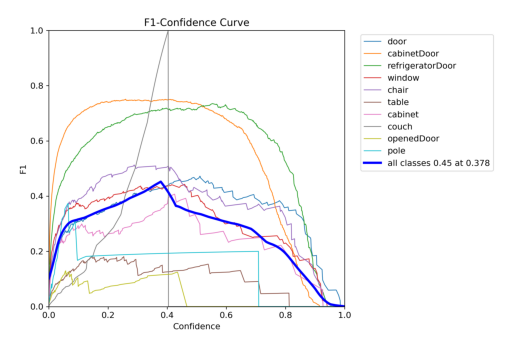



/kaggle/working/runs/detect/yolov9s_ppe_css_100_epochs/F1_curve.png


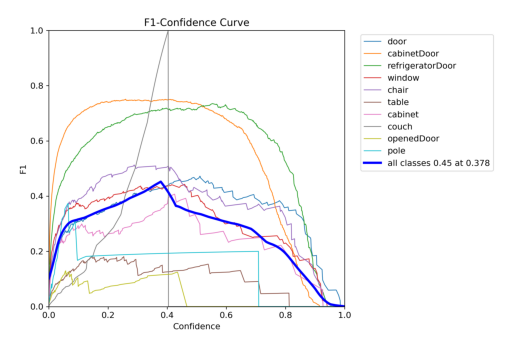



/kaggle/working/runs/detect/yolov9s_ppe_css_100_epochs/PR_curve.png


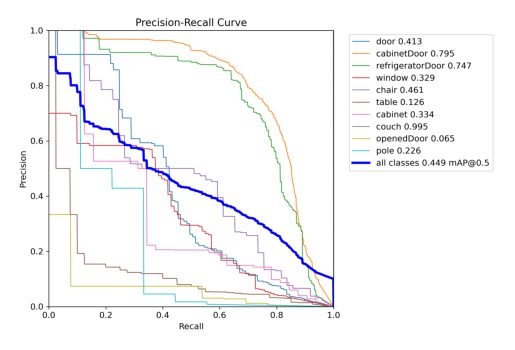



/kaggle/working/runs/detect/yolov9s_ppe_css_100_epochs/PR_curve.png


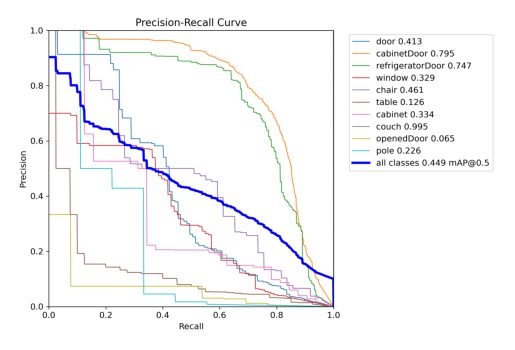



/kaggle/working/runs/detect/yolov9s_ppe_css_100_epochs/P_curve.png


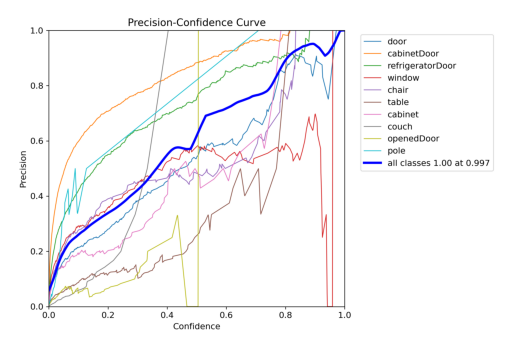



/kaggle/working/runs/detect/yolov9s_ppe_css_100_epochs/P_curve.png


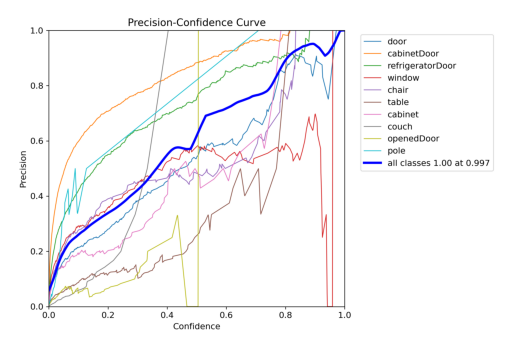



/kaggle/working/runs/detect/yolov9s_ppe_css_100_epochs/R_curve.png


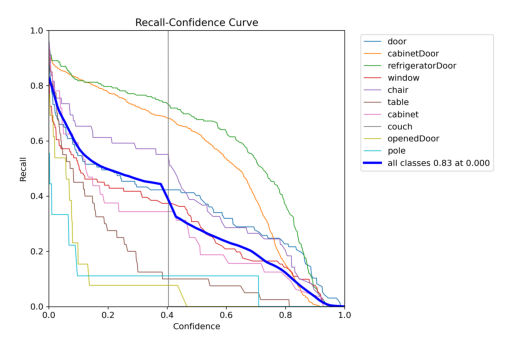



/kaggle/working/runs/detect/yolov9s_ppe_css_100_epochs/R_curve.png


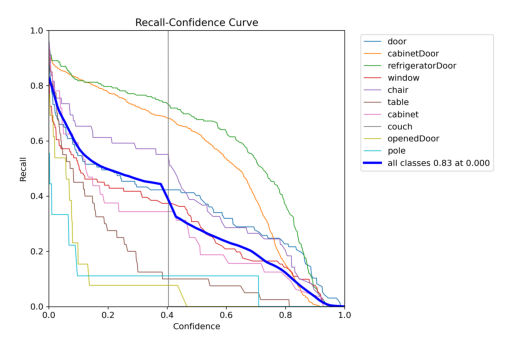



/kaggle/working/runs/detect/yolov9s_ppe_css_100_epochs/confusion_matrix.png


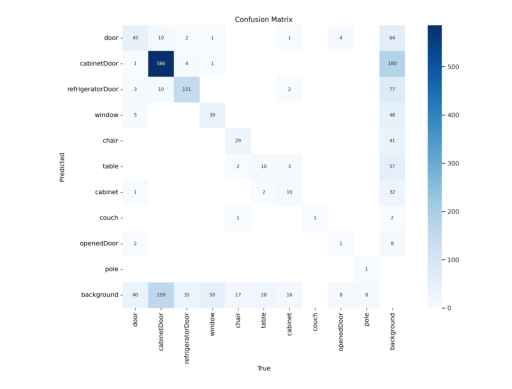



/kaggle/working/runs/detect/yolov9s_ppe_css_100_epochs/confusion_matrix.png


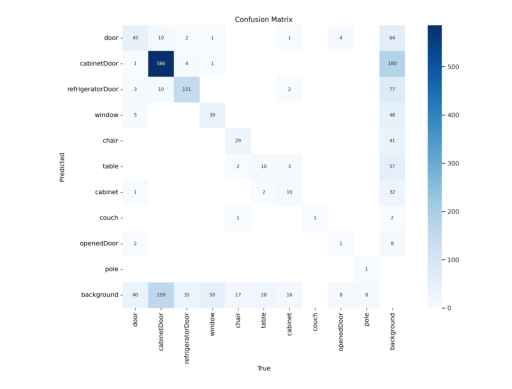



/kaggle/working/runs/detect/yolov9s_ppe_css_100_epochs/confusion_matrix_normalized.png


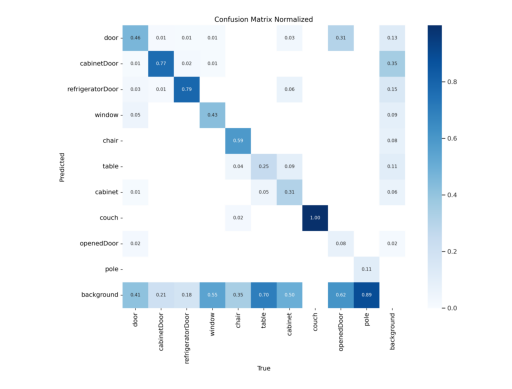



/kaggle/working/runs/detect/yolov9s_ppe_css_100_epochs/confusion_matrix_normalized.png


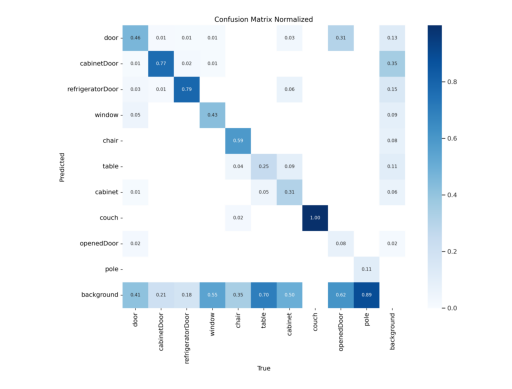



/kaggle/working/runs/detect/yolov9s_ppe_css_100_epochs/results.png


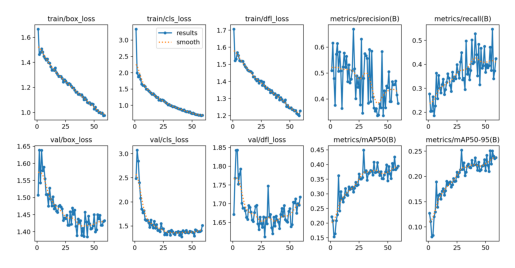



/kaggle/working/runs/detect/yolov9s_ppe_css_100_epochs/results.png


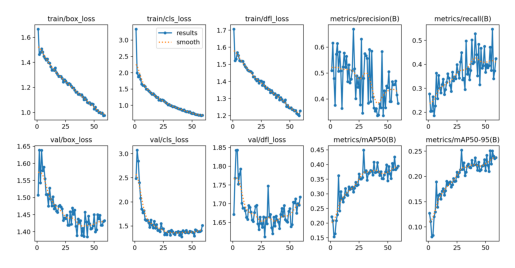

In [23]:
for file in sorted(results_paths):
    print(file)
    display_image(file, print_info = False, hide_axis = True)
    print('\n')

In [24]:
df = pd.read_csv(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/results.csv')
df = df.rename(columns=lambda x: x.replace(" ", ""))
df.to_csv(f'{CFG.OUTPUT_DIR}training_log_df.csv', index=False)
df

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,73.9409,1.66633,3.33950,1.70669,0.50901,0.27688,0.22157,0.12703,1.50694,2.48462,1.67120,0.000234,0.000234,0.000234
1,2,137.0590,1.46394,1.99563,1.52102,0.61605,0.20426,0.20753,0.11083,1.63892,3.07450,1.76839,0.000468,0.000468,0.000468
2,3,199.6990,1.47749,1.87579,1.53062,0.47866,0.20551,0.15328,0.08046,1.54309,2.84759,1.84282,0.000696,0.000696,0.000696
3,4,262.0920,1.50774,1.91559,1.56843,0.37525,0.26506,0.16378,0.08313,1.63804,2.39852,1.84314,0.000693,0.000693,0.000693
4,5,324.2900,1.48404,1.79732,1.55180,0.57227,0.18594,0.20855,0.12000,1.57912,2.07646,1.75247,0.000686,0.000686,0.000686
5,6,386.4530,1.44766,1.65233,1.52148,0.61408,0.22655,0.22918,0.12980,1.58899,1.85230,1.77883,0.000679,0.000679,0.000679
6,7,448.6700,1.43380,1.61313,1.51964,0.50693,0.36341,0.36220,0.18945,1.55516,1.77278,1.79257,0.000672,0.000672,0.000672
7,8,510.7940,1.41888,1.61314,1.51938,0.58136,0.25686,0.24140,0.13927,1.50868,1.81836,1.70118,0.000665,0.000665,0.000665
8,9,573.2230,1.42769,1.57700,1.51766,0.50889,0.35421,0.30718,0.16266,1.50913,1.63044,1.68832,0.000657,0.000657,0.000657
9,10,635.3990,1.39868,1.49523,1.49993,0.36386,0.30080,0.28319,0.16485,1.47506,1.61563,1.68835,0.000650,0.000650,0.000650


In [25]:
print('*'*50)
print('\nBest Training Box loss: ', df['train/box_loss'].min(), ', on epoch: ', df['train/box_loss'].argmin() + 1, '\n')
print('\nBest Validation Box loss: ', df['val/box_loss'].min(), ', on epoch: ', df['val/box_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training Cls loss: ', df['train/cls_loss'].min(), ', on epoch: ', df['train/cls_loss'].argmin() + 1, '\n')
print('\nBest Validation Cls loss: ', df['val/cls_loss'].min(), ', on epoch: ', df['val/cls_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training DFL loss: ', df['train/dfl_loss'].min(), ', on epoch: ', df['train/dfl_loss'].argmin() + 1, '\n')
print('\nBest Validation DFL loss: ', df['val/dfl_loss'].min(), ', on epoch: ', df['val/dfl_loss'].argmin() + 1, '\n')

**************************************************

Best Training Box loss:  0.97414 , on epoch:  58 


Best Validation Box loss:  1.38528 , on epoch:  44 


Best Training Cls loss:  0.68271 , on epoch:  58 


Best Validation Cls loss:  1.27584 , on epoch:  41 


Best Training DFL loss:  1.19939 , on epoch:  58 


Best Validation DFL loss:  1.6118 , on epoch:  28 



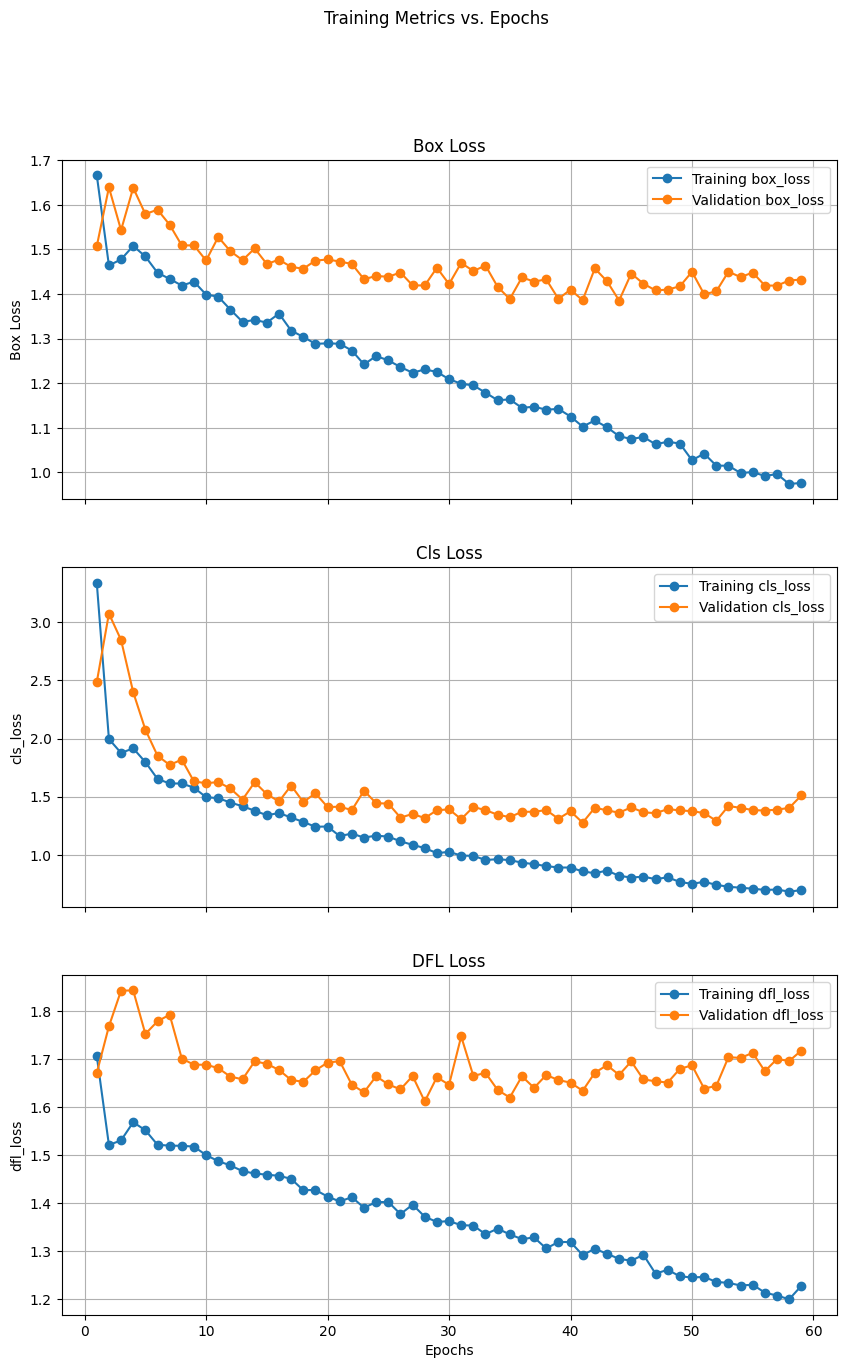

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

### Training and Validation box_loss
ax1.set_title('Box Loss')
ax1.plot(df['epoch'], df['train/box_loss'], label='Training box_loss', marker='o', linestyle='-')
ax1.plot(df['epoch'], df['val/box_loss'], label='Validation box_loss', marker='o', linestyle='-')
ax1.set_ylabel('Box Loss')
ax1.legend()
ax1.grid(True)

### Training and Validation cls_loss
ax2.set_title('Cls Loss')
ax2.plot(df['epoch'], df['train/cls_loss'], label='Training cls_loss', marker='o', linestyle='-')
ax2.plot(df['epoch'], df['val/cls_loss'], label='Validation cls_loss', marker='o', linestyle='-')
ax2.set_ylabel('cls_loss')
ax2.legend()
ax2.grid(True)

### Training and Validation dfl_loss
ax3.set_title('DFL Loss')
ax3.plot(df['epoch'], df['train/dfl_loss'], label='Training dfl_loss', marker='o', linestyle='-')
ax3.plot(df['epoch'], df['val/dfl_loss'], label='Validation dfl_loss', marker='o', linestyle='-')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('dfl_loss')
ax3.legend()
ax3.grid(True)

plt.suptitle('Training Metrics vs. Epochs')
plt.show()

In [27]:
validation_results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'val_batch' in i
]

len(validation_results_paths)

6

In [28]:
if len(validation_results_paths) >= 1:
    print(validation_results_paths[-1])

/kaggle/working/runs/detect/yolov9s_ppe_css_100_epochs/val_batch0_labels.jpg


/kaggle/working/runs/detect/yolov9s_ppe_css_100_epochs/val_batch0_labels.jpg


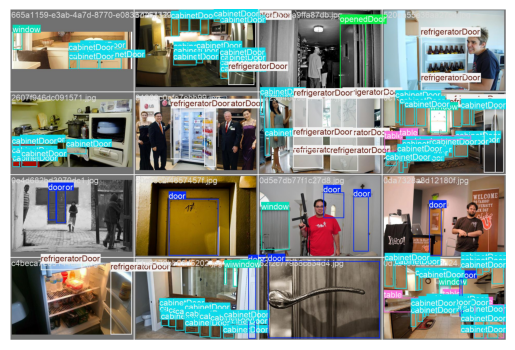

In [29]:
### check predictions or labels from a random validation batch
if len(validation_results_paths) >= 1:
    val_img_path = random.choice(validation_results_paths)
    print(val_img_path)
    display_image(val_img_path, print_info = False, hide_axis = True)

# Result analysis

In this analysis, using the indoor-object-detection dataset and the YOLO model it is evident that the convolutional neural network for classification of elments found in the images.

Following the initial running of the model the results were that the model worked but the accuracy was quite low, here I trained the model using 100 epochs with the YOLOv8s model the ultimate result showed an F1 confidence of 42% at a confidence level of around 20%. This was following around 40minues of training required to train the model. This earlier version of YOLO also showed that there were many of the smaller elements that were often confused for the background. However the learning curves for the 

Following this result I devided to once agin run the analysis using a newer version being YOLOv9s. This trianing was similarly training for 100 epochs, however took 2.2hours. This newer model showed slightly improved results in the space of the F1-Confidence curves with the model being able to accurately identify 45% of the items at a 23% confidence, this is an improvement on the previous model however shows that there is still a lot of room for imporvement. For the F1, precision and recall graphs it is evident that there are classes that are outperforming (cabinetDoor and refrigeratorDoor) who are getting F1 scores close to 80% showing that the classes with more instances have better overall perfromance. This behaviour is also evident in the normalized confusion matrix graphs as the classes that have low represntation in the dataset are often confused with the background. Another interesting ocurrence is that the openDoor and door class are often confused with each other in the normalized confusion matrix showing that there is possibly training ocurring based on the general shape of the door including the frame which causes the confusion.

The loss function grpahs also show that there is some overtraining ocurring as the box loss and cls loss are flattening on the test data while they are decreasing in the train data, the overfitting is also most evident in the DFL loss, which is actually becoming worse over time showing that the extra training on the train data is not generalizing to the test dataset.

Based on these elements, the conculsion is that the training was adequate for some of the classes but not for all of them. In order to further improve the performance of the model there is room to decrease the learning rate from the current 1e-5 and to increase the amount of epochs. This will increase the training time, however may bring the results needed. This recommendation is based on the volatile graphs seen in the percision and recall metrics graphs. Another possible area would be to increase the amount of images in the training dataset using image transformation as due to the low amount of some classes, there were issues with the training.
